In [1]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    """
    For a given observation, compute Q values for each action
        Attributes
    ----------
    lr: float
        learning rate
    input_dims : list
        [8]
    fc1_dims : int
        fully-connected layer 1
    fc2_dims : int
        fully-connected layer 2
    n_actions : int
        the number of actions
    """
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions, weight_decay=1e-5,p=0.5):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
#        self.dropout = nn.Dropout(p) 
        self.optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)
#        self.loss = nn.MSELoss()
        self.loss = nn.SmoothL1Loss() # Huber loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
#        x = self.dropout(x) # dropout for regularization
        actions = self.fc3(x)
        
        return actions

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                max_mem_size=100000, eps_end=0.01, eps_dec=1e-5, weight_decay=1e-5):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)] # list of actions
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, 
                                  fc1_dims=32, fc2_dims=32, weight_decay=weight_decay)
        
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype= np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
        
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # residual. The memory is finite, so we are reusing
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] =  action
        self.terminal_memory[index] = done
        
        self.mem_cntr += 1
        
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device) # [] is used because of the nn library. torch.Size([1, 6])
            actions = self.Q_eval.forward(state)
            action = T.argmax(actions).item() # .item() to get integer
        else:
            action = np.random.choice(self.action_space)
            
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size) 
        # select samples the number of self.batch_size out of max_mem 
        batch = np.random.choice(max_mem, self.batch_size, replace=False) # Don't select the same thing again
        # array slicing [0,1,2,...,self.batch_size-1]
        batch_index = np.arange(self.batch_size, dtype=np.int32) 
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0
                                                 
        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
        
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        

In [2]:
from env import TradingSPYEnv
import numpy as np
env = TradingSPYEnv(init_invest=100.0, sma_len=[5,25,50,100])
num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.n
print("Size of Action Space ->  {}".format(num_actions))

agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=num_actions, eps_end=0.01, input_dims = [num_states], lr=0.003,
              weight_decay=1e-5)
scores, eps_history = [], []
n_games = 1000


for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    if observation.dtype == np.float64:
        observation = observation.astype(np.float32)
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        if (observation_ is not None): 
            if (observation_.dtype == np.float64):
                observation_ = observation_.astype(np.float32)
            score += reward
            agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    avg_score = np.mean(scores[-100:])
    
    print('episode ', i, 'score %.2f' % score,
         'average score %.2f' % avg_score,
         'epsilon %.2f ' % agent.epsilon,
         'profit_iteration %.2f ' % info['profit_iteration'],
         'iterations %.2f ' % info['iterations'],
         'long_return %.2f ' % info['long_return']
         )


C:\Users\golde\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Size of State Space ->  8
Size of Action Space ->  3
episode  0 score -39.57 average score -39.57 epsilon 0.97  profit_iteration -0.01  iterations 3520.00  long_return 3.33 
episode  1 score 35.56 average score -2.01 epsilon 0.95  profit_iteration 0.02  iterations 1746.00  long_return 2.54 
episode  2 score -7.06 average score -3.69 epsilon 0.93  profit_iteration -0.01  iterations 1299.00  long_return 1.86 
episode  3 score 18.59 average score 1.88 epsilon 0.92  profit_iteration 0.02  iterations 1015.00  long_return 1.53 
episode  4 score 134.56 average score 28.42 epsilon 0.88  profit_iteration 0.03  iterations 4054.00  long_return 3.64 
episode  5 score 24.89 average score 27.83 epsilon 0.87  profit_iteration 0.02  iterations 1691.00  long_return 2.62 
episode  6 score 5.05 average score 24.57 epsilon 0.86  profit_iteration 0.00  iterations 1030.00  long_return 1.54 
episode  7 score -15.97 average score 19.51 epsilon 0.85  profit_iteration -0.02  iterations 1044.00  long_return 1.60

episode  69 score 41.73 average score 73.05 epsilon 0.01  profit_iteration 0.06  iterations 727.00  long_return 1.44 
episode  70 score 252.16 average score 75.57 epsilon 0.01  profit_iteration 0.07  iterations 3795.00  long_return 3.76 
episode  71 score 213.54 average score 77.49 epsilon 0.01  profit_iteration 0.10  iterations 2040.00  long_return 2.95 
episode  72 score 371.72 average score 81.52 epsilon 0.01  profit_iteration 0.16  iterations 2344.00  long_return 4.26 
episode  73 score 238.25 average score 83.64 epsilon 0.01  profit_iteration 0.06  iterations 3769.00  long_return 3.77 
episode  74 score 97.59 average score 83.82 epsilon 0.01  profit_iteration 0.08  iterations 1248.00  long_return 1.81 
episode  75 score 125.69 average score 84.37 epsilon 0.01  profit_iteration 0.03  iterations 4054.00  long_return 3.64 
episode  76 score 204.79 average score 85.94 epsilon 0.01  profit_iteration 0.06  iterations 3550.00  long_return 3.29 
episode  77 score 231.87 average score 87.8

episode  137 score 36.41 average score 144.59 epsilon 0.01  profit_iteration 0.04  iterations 838.00  long_return 1.44 
episode  138 score 228.03 average score 144.65 epsilon 0.01  profit_iteration 0.10  iterations 2233.00  long_return 3.22 
episode  139 score 40.61 average score 144.63 epsilon 0.01  profit_iteration 0.06  iterations 694.00  long_return 1.47 
episode  140 score 79.53 average score 145.20 epsilon 0.01  profit_iteration 0.06  iterations 1221.00  long_return 1.84 
episode  141 score -2.91 average score 144.78 epsilon 0.01  profit_iteration -0.03  iterations 122.00  long_return 1.01 
episode  142 score 98.14 average score 144.86 epsilon 0.01  profit_iteration 0.03  iterations 3071.00  long_return 2.70 
episode  143 score 265.14 average score 147.01 epsilon 0.01  profit_iteration 0.07  iterations 4020.00  long_return 4.75 
episode  144 score 162.17 average score 148.60 epsilon 0.01  profit_iteration 0.06  iterations 2704.00  long_return 2.21 
episode  145 score 162.12 avera

episode  205 score 74.21 average score 134.03 epsilon 0.01  profit_iteration 0.03  iterations 2879.00  long_return 2.42 
episode  206 score 50.27 average score 134.02 epsilon 0.01  profit_iteration 0.04  iterations 1107.00  long_return 1.64 
episode  207 score 2.63 average score 132.74 epsilon 0.01  profit_iteration 0.05  iterations 41.00  long_return 1.02 
episode  208 score 159.66 average score 132.48 epsilon 0.01  profit_iteration 0.05  iterations 3453.00  long_return 3.29 
episode  209 score 43.83 average score 130.26 epsilon 0.01  profit_iteration 0.04  iterations 1218.00  long_return 1.82 
episode  210 score 84.78 average score 128.85 epsilon 0.01  profit_iteration 0.03  iterations 2788.00  long_return 2.28 
episode  211 score 173.07 average score 129.10 epsilon 0.01  profit_iteration 0.06  iterations 3022.00  long_return 2.79 
episode  212 score 106.21 average score 127.53 epsilon 0.01  profit_iteration 0.07  iterations 1563.00  long_return 2.29 
episode  213 score 180.63 averag

episode  273 score 269.04 average score 136.73 epsilon 0.01  profit_iteration 0.07  iterations 3814.00  long_return 3.95 
episode  274 score 267.58 average score 138.69 epsilon 0.01  profit_iteration 0.07  iterations 3622.00  long_return 3.22 
episode  275 score 112.13 average score 138.88 epsilon 0.01  profit_iteration 0.07  iterations 1608.00  long_return 2.31 
episode  276 score 6.38 average score 138.28 epsilon 0.01  profit_iteration 0.03  iterations 167.00  long_return 1.08 
episode  277 score 76.55 average score 136.18 epsilon 0.01  profit_iteration 0.06  iterations 1338.00  long_return 1.99 
episode  278 score 25.58 average score 136.19 epsilon 0.01  profit_iteration 0.05  iterations 523.00  long_return 1.39 
episode  279 score 50.34 average score 135.67 epsilon 0.01  profit_iteration 0.06  iterations 875.00  long_return 1.47 
episode  280 score 144.07 average score 136.69 epsilon 0.01  profit_iteration 0.06  iterations 2219.00  long_return 3.09 
episode  281 score 172.13 averag

episode  341 score 259.20 average score 147.30 epsilon 0.01  profit_iteration 0.11  iterations 2322.00  long_return 3.92 
episode  342 score 112.43 average score 147.94 epsilon 0.01  profit_iteration 0.06  iterations 1818.00  long_return 2.44 
episode  343 score 158.61 average score 149.06 epsilon 0.01  profit_iteration 0.04  iterations 3587.00  long_return 3.21 
episode  344 score 130.55 average score 149.96 epsilon 0.01  profit_iteration 0.04  iterations 3319.00  long_return 3.08 
episode  345 score 40.94 average score 148.41 epsilon 0.01  profit_iteration 0.04  iterations 1003.00  long_return 1.53 
episode  346 score 180.53 average score 150.00 epsilon 0.01  profit_iteration 0.05  iterations 3415.00  long_return 3.02 
episode  347 score 59.10 average score 149.17 epsilon 0.01  profit_iteration 0.05  iterations 1100.00  long_return 1.63 
episode  348 score 122.33 average score 147.04 epsilon 0.01  profit_iteration 0.07  iterations 1639.00  long_return 2.47 
episode  349 score 108.78 

episode  409 score 397.65 average score 147.78 epsilon 0.01  profit_iteration 0.10  iterations 3804.00  long_return 3.85 
episode  410 score 35.66 average score 146.93 epsilon 0.01  profit_iteration 0.06  iterations 536.00  long_return 1.39 
episode  411 score 87.06 average score 144.51 epsilon 0.01  profit_iteration 0.06  iterations 1325.00  long_return 1.97 
episode  412 score 31.40 average score 144.79 epsilon 0.01  profit_iteration 0.08  iterations 403.00  long_return 1.30 
episode  413 score 44.26 average score 143.90 epsilon 0.01  profit_iteration 0.05  iterations 913.00  long_return 1.44 
episode  414 score 279.08 average score 143.89 epsilon 0.01  profit_iteration 0.07  iterations 3825.00  long_return 4.08 
episode  415 score 340.84 average score 144.22 epsilon 0.01  profit_iteration 0.09  iterations 3884.00  long_return 4.43 
episode  416 score 182.60 average score 142.33 epsilon 0.01  profit_iteration 0.09  iterations 2001.00  long_return 2.95 
episode  417 score 33.54 averag

episode  477 score 55.22 average score 151.01 epsilon 0.01  profit_iteration 0.09  iterations 596.00  long_return 1.50 
episode  478 score 154.97 average score 149.71 epsilon 0.01  profit_iteration 0.05  iterations 2882.00  long_return 2.45 
episode  479 score 158.86 average score 149.37 epsilon 0.01  profit_iteration 0.08  iterations 1883.00  long_return 2.49 
episode  480 score 50.94 average score 145.90 epsilon 0.01  profit_iteration 0.05  iterations 988.00  long_return 1.57 
episode  481 score 260.79 average score 147.65 epsilon 0.01  profit_iteration 0.11  iterations 2278.00  long_return 3.71 
episode  482 score 142.01 average score 148.12 epsilon 0.01  profit_iteration 0.05  iterations 2669.00  long_return 2.34 
episode  483 score 1.00 average score 147.81 epsilon 0.01  profit_iteration 0.01  iterations 24.00  long_return 1.00 
episode  484 score 182.70 average score 147.98 epsilon 0.01  profit_iteration 0.06  iterations 2988.00  long_return 2.73 
episode  485 score 77.04 average

episode  545 score 126.47 average score 155.11 epsilon 0.01  profit_iteration 0.04  iterations 2991.00  long_return 2.72 
episode  546 score 224.71 average score 156.29 epsilon 0.01  profit_iteration 0.09  iterations 2572.00  long_return 2.49 
episode  547 score 232.06 average score 156.95 epsilon 0.01  profit_iteration 0.06  iterations 3596.00  long_return 3.28 
episode  548 score 37.24 average score 156.25 epsilon 0.01  profit_iteration 0.04  iterations 810.00  long_return 1.40 
episode  549 score 33.01 average score 154.78 epsilon 0.01  profit_iteration 0.08  iterations 447.00  long_return 1.33 
episode  550 score 155.41 average score 154.97 epsilon 0.01  profit_iteration 0.07  iterations 2067.00  long_return 2.70 
episode  551 score 8.86 average score 154.83 epsilon 0.01  profit_iteration 0.04  iterations 181.00  long_return 1.10 
episode  552 score 132.44 average score 155.34 epsilon 0.01  profit_iteration 0.07  iterations 1768.00  long_return 2.42 
episode  553 score 189.30 avera

episode  613 score 220.52 average score 133.26 epsilon 0.01  profit_iteration 0.06  iterations 3384.00  long_return 3.07 
episode  614 score 105.39 average score 133.85 epsilon 0.01  profit_iteration 0.08  iterations 1386.00  long_return 2.12 
episode  615 score 144.76 average score 132.44 epsilon 0.01  profit_iteration 0.07  iterations 2081.00  long_return 2.75 
episode  616 score 180.09 average score 132.51 epsilon 0.01  profit_iteration 0.06  iterations 2992.00  long_return 2.72 
episode  617 score 198.41 average score 132.54 epsilon 0.01  profit_iteration 0.08  iterations 2525.00  long_return 2.66 
episode  618 score 68.72 average score 130.99 epsilon 0.01  profit_iteration 0.06  iterations 1128.00  long_return 1.64 
episode  619 score 465.36 average score 134.08 epsilon 0.01  profit_iteration 0.12  iterations 3965.00  long_return 4.84 
episode  620 score 297.90 average score 134.73 epsilon 0.01  profit_iteration 0.12  iterations 2417.00  long_return 3.97 
episode  621 score 24.66 

episode  681 score 229.55 average score 141.81 epsilon 0.01  profit_iteration 0.07  iterations 3401.00  long_return 3.08 
episode  682 score 126.22 average score 142.59 epsilon 0.01  profit_iteration 0.09  iterations 1420.00  long_return 2.28 
episode  683 score 133.22 average score 142.83 epsilon 0.01  profit_iteration 0.09  iterations 1428.00  long_return 2.17 
episode  684 score 14.12 average score 142.17 epsilon 0.01  profit_iteration 0.05  iterations 256.00  long_return 1.16 
episode  685 score 2.88 average score 140.40 epsilon 0.01  profit_iteration 0.18  iterations 12.00  long_return 1.01 
episode  686 score 81.81 average score 139.51 epsilon 0.01  profit_iteration 0.03  iterations 3059.00  long_return 2.75 
episode  687 score 51.15 average score 138.93 epsilon 0.01  profit_iteration 0.07  iterations 723.00  long_return 1.51 
episode  688 score 120.82 average score 138.81 epsilon 0.01  profit_iteration 0.06  iterations 2088.00  long_return 2.80 
episode  689 score 28.91 average 

episode  749 score 293.22 average score 134.68 epsilon 0.01  profit_iteration 0.09  iterations 3383.00  long_return 3.06 
episode  750 score 143.99 average score 135.77 epsilon 0.01  profit_iteration 0.06  iterations 2509.00  long_return 2.66 
episode  751 score 119.65 average score 136.50 epsilon 0.01  profit_iteration 0.07  iterations 1801.00  long_return 2.39 
episode  752 score 5.12 average score 134.61 epsilon 0.01  profit_iteration 0.06  iterations 79.00  long_return 1.03 
episode  753 score 130.40 average score 134.76 epsilon 0.01  profit_iteration 0.08  iterations 1515.00  long_return 2.29 
episode  754 score 134.25 average score 135.03 epsilon 0.01  profit_iteration 0.04  iterations 3428.00  long_return 3.08 
episode  755 score 22.40 average score 134.85 epsilon 0.01  profit_iteration 0.05  iterations 425.00  long_return 1.35 
episode  756 score 169.91 average score 136.13 epsilon 0.01  profit_iteration 0.09  iterations 1946.00  long_return 2.75 
episode  757 score 2.89 averag

episode  817 score 94.47 average score 133.59 epsilon 0.01  profit_iteration 0.07  iterations 1307.00  long_return 1.92 
episode  818 score 188.05 average score 133.79 epsilon 0.01  profit_iteration 0.05  iterations 3636.00  long_return 3.26 
episode  819 score 264.48 average score 133.81 epsilon 0.01  profit_iteration 0.11  iterations 2443.00  long_return 3.89 
episode  820 score 9.34 average score 132.42 epsilon 0.01  profit_iteration 0.05  iterations 164.00  long_return 1.09 
episode  821 score 117.87 average score 133.21 epsilon 0.01  profit_iteration 0.06  iterations 1882.00  long_return 2.49 
episode  822 score 140.46 average score 134.06 epsilon 0.01  profit_iteration 0.08  iterations 1821.00  long_return 2.44 
episode  823 score 363.70 average score 134.33 epsilon 0.01  profit_iteration 0.09  iterations 3838.00  long_return 4.30 
episode  824 score 163.97 average score 134.50 epsilon 0.01  profit_iteration 0.05  iterations 3385.00  long_return 3.09 
episode  825 score 168.39 av

episode  885 score 170.44 average score 138.69 epsilon 0.01  profit_iteration 0.08  iterations 2131.00  long_return 3.01 
episode  886 score 246.60 average score 139.05 epsilon 0.01  profit_iteration 0.07  iterations 3601.00  long_return 3.36 
episode  887 score 57.57 average score 138.01 epsilon 0.01  profit_iteration 0.06  iterations 957.00  long_return 1.50 
episode  888 score 174.49 average score 139.70 epsilon 0.01  profit_iteration 0.05  iterations 3343.00  long_return 3.07 
episode  889 score 228.81 average score 141.96 epsilon 0.01  profit_iteration 0.13  iterations 1740.00  long_return 2.84 
episode  890 score 260.81 average score 141.24 epsilon 0.01  profit_iteration 0.06  iterations 4002.00  long_return 4.07 
episode  891 score 156.12 average score 141.24 epsilon 0.01  profit_iteration 0.05  iterations 2973.00  long_return 2.67 
episode  892 score 276.61 average score 142.63 epsilon 0.01  profit_iteration 0.07  iterations 3717.00  long_return 3.60 
episode  893 score 307.44 

episode  953 score 108.89 average score 140.63 epsilon 0.01  profit_iteration 0.04  iterations 2847.00  long_return 2.44 
episode  954 score 255.04 average score 143.23 epsilon 0.01  profit_iteration 0.08  iterations 3130.00  long_return 2.81 
episode  955 score 219.65 average score 145.08 epsilon 0.01  profit_iteration 0.10  iterations 2214.00  long_return 3.11 
episode  956 score 10.42 average score 143.85 epsilon 0.01  profit_iteration 0.05  iterations 177.00  long_return 1.10 
episode  957 score 288.86 average score 145.43 epsilon 0.01  profit_iteration 0.07  iterations 3922.00  long_return 4.17 
episode  958 score 33.67 average score 144.08 epsilon 0.01  profit_iteration 0.04  iterations 740.00  long_return 1.40 
episode  959 score 208.39 average score 144.73 epsilon 0.01  profit_iteration 0.06  iterations 3281.00  long_return 3.00 
episode  960 score 225.66 average score 146.78 epsilon 0.01  profit_iteration 0.06  iterations 3758.00  long_return 3.85 
episode  961 score 101.78 av

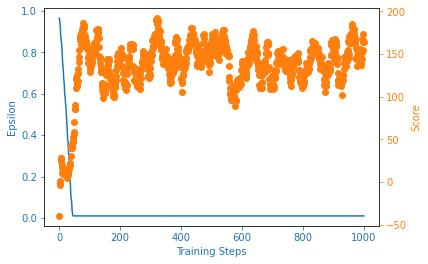

In [3]:
from utils import plot_learning_curve
import os
x = [i+1 for i in range(n_games)]
filename = 'Phil-deepQ-huber.png'
plot_learning_curve(x, scores, eps_history, filename)
state_dict_path = os.path.join(os.getcwd(),'test-huber.pth')
T.save(agent.Q_eval.state_dict(), state_dict_path)

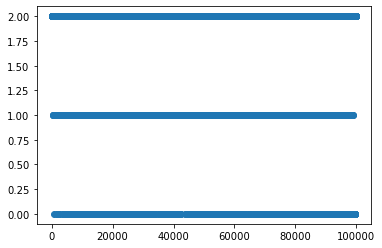

In [4]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(agent.action_memory)),agent.action_memory)

In [5]:
agent.Q_eval.load_state_dict(T.load(state_dict_path)) # load saved model

<All keys matched successfully>

In [6]:
print(agent.state_memory[-4:],
        agent.new_state_memory[-4:], 
        agent.action_memory[-4:], 
        agent.reward_memory[-4:], 
        agent.terminal_memory[-4:])

[[  2.          0.        152.05455     1.739531    1.7576133   1.7424724
    1.7368816   1.685837 ]
 [  2.          0.        151.84721     1.737159    1.7498951   1.7422389
    1.7374784   1.6873597]
 [  2.          0.        152.2938      1.7422681   1.7436913   1.7428628
    1.7378031   1.6891735]
 [  2.          0.        151.72758     1.7357905   1.7395493   1.7432096
    1.7384125   1.6907089]] [[  2.          0.        151.84721     1.737159    1.7498951   1.7422389
    1.7374784   1.6873597]
 [  2.          0.        152.2938      1.7422681   1.7436913   1.7428628
    1.7378031   1.6891735]
 [  2.          0.        151.72758     1.7357905   1.7395493   1.7432096
    1.7384125   1.6907089]
 [  2.          0.        152.70848     1.7470121   1.7403522   1.7446072
    1.7391534   1.692529 ]] [2. 2. 2. 2.] [-0.30304047 -0.20734349  0.44658598 -0.56620723] [False False False False]


In [9]:
tmp = agent.action_memory
print('mean', np.mean(tmp))
print('max', np.max(tmp))
print('min', np.min(tmp))

mean 1.95902
max 2.0
min 0.0


In [8]:
info

{'profit_iteration': 0.08684868223528691,
 'iterations': 3871,
 'long_return': 4.454301075268817}